# SQUID example of variant effect prediction using Kipoi model (DeepSTARR)

In [ ]:
!pip install squid-nn --quiet
!pip install logomaker --quiet
!pip install mavenn --quiet --upgrade
!pip install kipoi --quiet --upgrade #ignore pip dependency resolver warnings
!pip install kipoiseq --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jsonschema 4.19.1 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
referencing 0.30.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
     ━━━━━━━━

In [ ]:
import numpy as np
import mavenn
import squid
from tqdm import tqdm
import kipoi

## generate in silico MAVE based on sequence of interest

In [ ]:
task_idx = 0                  # deepstarr task index (either 0 Dev or 1 HK)
alphabet = ['A','C','G','T']

# define sequence of interest
seq = 'GGCTCTGTCTCAGTTTCTGATTCAGTTTCGGATCCACTTCGAGAGGCAGAAGTCGGGGTCCGAGAGGCATTAGCTTGTTAGTTCTACAACCTGCTGGCAAATGTGCCAATATGTTTGCACGCTGATAAGGCCTACATGGCACCGAATTGAAAACCGCTTACATAATGAAGTGAATAGTCAGCGAATCGGCAGAGCAACCGCAATGCATTGCATTCACCATCGCGAATAATCAGATTCAAGGCAACGATC'

# convert to one-hot
x = squid.utils.seq2oh(seq, alphabet)

# instantiate kipoi model for deepstarr
model = kipoi.get_model('DeepSTARR')

# define how to go from kipoi prediction to scalar
kipoi_predictor = squid.predictor.ScalarPredictor(model.predict_on_batch, task_idx=task_idx, batch_size=512)

# set up mutagenizer class for in silico MAVE
mut_generator = squid.mutagenizer.RandomMutagenesis(mut_rate=0.1, uniform=False)

# generate in silico MAVE
seq_length = len(x)
mut_window = [0, seq_length]      # interval in sequence to mutagenize
num_sim = 20000                   # number of sequence to simulate
mave = squid.mave.InSilicoMAVE(mut_generator, mut_predictor=kipoi_predictor, seq_length=seq_length, mut_window=mut_window)
x_mut, y_mut = mave.generate(x, num_sim=num_sim)


16.4kB [00:00, 33.7kB/s]                            


2.56MB [00:00, 3.35MB/s]                            



Building in silico MAVE...


## Fit in silico MAVE with surrogate model

In [ ]:
# choose surrogate model type
gpmap = 'additive'

# MAVE-NN model with GE nonlinearity
surrogate_model = squid.surrogate_zoo.SurrogateMAVENN(x_mut.shape, num_tasks=y_mut.shape[1],
                                                gpmap=gpmap, regression_type='GE',
                                                linearity='nonlinear', noise='SkewedT',
                                                noise_order=2, reg_strength=0.1,
                                                alphabet=alphabet, deduplicate=True,
                                                gpu=True)

# train surrogate model
surrogate, mave_df = surrogate_model.train(x_mut, y_mut, learning_rate=5e-4, epochs=500, batch_size=100,
                                           early_stopping=True, patience=25, restore_best_weights=True,
                                           save_dir=None, verbose=1)

# retrieve model parameters
params = surrogate_model.get_params(gauge='empirical')

# generate sequence logo
logo = surrogate_model.get_logo(mut_window=mut_window, full_length=seq_length)

# Fix gauge for variant effect prediction
variant_effect = squid.utils.fix_gauge(logo, gauge='wildtype', wt=x_mut[0])

# save variant effects to pandas
variant_effect_df = squid.utils.arr2pd(variant_effect, alphabet)
variant_effect_df

  Creating sequence dataframe...

              y                                                  x
0      2.478563  GGCTCTGTCTCAGTTTCTGATTCAGTTTCGGATCCACTTCGAGAGG...
1     -0.098738  GGCTCTGTCTCAGTTTCTGACTCAGTTTCGGATCCAGTCCGAGAGC...
2      0.867421  GGTTCTGTCTCAGTTCCTGATTCAGTTTCGGATCCACGTAGAGAGG...
3      1.297172  GGCTCTGTCTCAGTTTCTGATCCAGTTTCGGAACCACTTCGAGAGG...
4     -0.538249  GGCTCGGTCTAAGTTCCTAATTCAGTTTCGGATCGACTTCGAGAGG...
...         ...                                                ...
19995  1.446890  GGCTCTGTCTAAGTTTCTGATTCAGTTTGGTATTCAATTCGAGAGG...
19996 -0.209101  GGCTCGGTCTCAGTTTCTGATTAAGTTTCGGGTCCACTTCAAGGGG...
19997 -0.574748  GGCTCTGTCTCAGTTTGTGATTCAGTTTCGGATCCACTTTAAGAGG...
19998  2.520661  GGCTCTGTCTCAGTTTCGGATTCAGTTTCGGCTCCACTTCGAGAGG...
19999  1.954255  GGCTTTGTCTCAGTTTCTGATTCAGTTGCGGATCCACTTCGTGAGG...

[20000 rows x 2 columns]
Training set   :   12,031 observations (  60.16%)
Validation set :    4,076 observations (  20.38%)
Test set       :    3,893 observatio

0epoch [00:00, ?epoch/s]

Training time: 104.1 seconds


,A,C,G,T
0,0.005135,0.041364,0.000000,-0.018157
1,0.013317,0.013663,0.000000,0.051724
2,-0.039488,0.000000,0.016300,0.040646
3,-0.007794,-0.020204,-0.003913,0.000000
4,-0.001132,0.000000,-0.005161,0.021053
...,...,...,...,...
244,0.028295,0.000000,0.003028,0.049823
245,-0.006987,0.005695,0.000000,-0.015752
246,0.000000,-0.024745,0.028708,-0.003605
247,0.029891,-0.012484,0.049556,0.000000


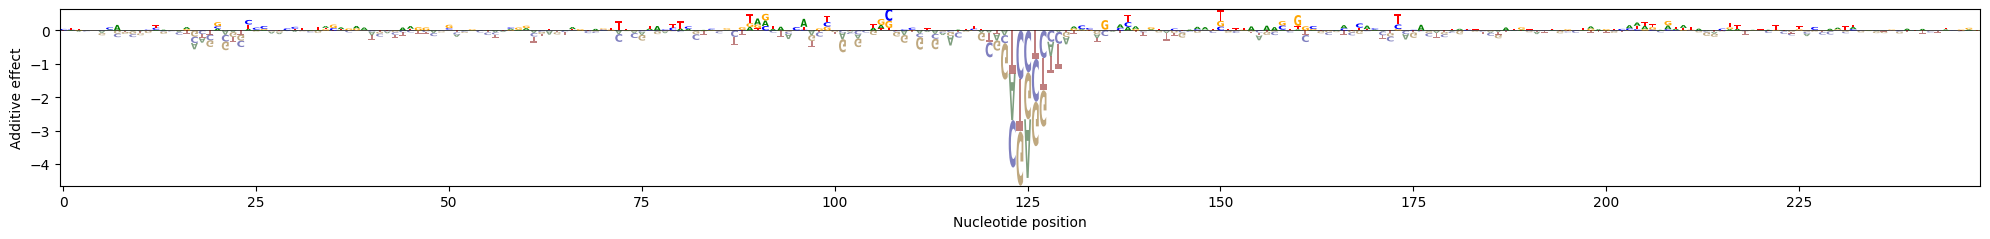

In [ ]:
# plot additive logo in wildtype gauge
squid.impress.plot_additive_logo(variant_effect, center=False, view_window=mut_window, alphabet=alphabet, fig_size=[20,2.5]);